# Proglearn: Scene Segmentation of ISIC using Scikit-Image
*Neuro Data Design II: Spring 2022*


This tutorial provides a walkthrough to applying a Random Forest model to perform scene segmentation on images taken from the International Skin Imaging Collaboration (ISIC) dataset from 2016 using Scikit-Image. 


**Contributor**: Amy van Ee (avanee1@jhu.edu)

## 0. Environment Setup

To start this tutorial, we will first import the necessary packages and functions.

In [1]:
# ========================================================#
# import packages

# for handling the dataset
import cv2
import os

# for processing the dataset and visualization
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

# for scene segmentation
from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

# original functions for scene segmentation
from functions.scene_segmentation_rf_isic_exp_functions import (
    get_dice,
    perform_scene_seg,
)

# for analyzing scene segmentation performance
from skimage.metrics import adapted_rand_error, variation_of_information

## I. Preprocessing of Images

**Loading the Dataset**

Now, we will retrieve images from the ISIC dataset.

In [2]:
# ========================================================#
# retrieve data

# input location of data
dataloc = "C:/Users/Amy/Documents/Python/Neuro Data Design/"

# extract images
datalbl = dataloc + "NDD II/ISIC/ISBI2016_ISIC_Part1_Training_GroundTruth/"
dataimg = dataloc + "NDD II/ISIC/ISBI2016_ISIC_Part1_Training_Data/"

lblpaths = [datalbl + im for im in os.listdir(datalbl)]
imgpaths = [dataimg + im for im in os.listdir(dataimg)]

# sort and print information
imgpaths.sort()
lblpaths.sort()
print("Total # of images =", len(imgpaths))
print("Total # of labels =", len(lblpaths))

Total # of images = 1279
Total # of labels = 1279


Next, we will load all of our images into the workspace. Each image has true annotations where its component pixels are labeled as being part of one of two categories -- normal or cancerous tissue. The labels are converted to greyscale as required by the classifier in the subsequent parts of this tutorial.

In [4]:
# ========================================================#
# load all images
images = [cv2.imread(img) for img in imgpaths]
labels_grey = np.array(
    [(rgb2gray(cv2.imread(lblpath)) * 1000).astype(int) for lblpath in lblpaths]
)

C:\Users\Amy\AppData\Local\Temp\ipykernel_58420\2779197301.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels_grey = np.array(


**Visualize an Example Image**

Having loaded in our dataset, we will now try to familiarize ourself with it. We will choose a sample image from the ISIC dataset to see the original image adjacent to the annotated image.

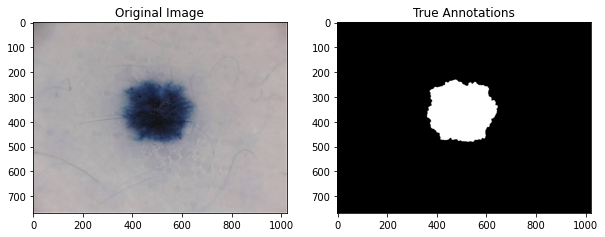

In [5]:
# ========================================================#
# Plot the original image alongside the annotated image

# Prepare plot
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 10)

# import image 1
image = cv2.imread(imgpaths[1])
# import annotation for image 1 and convert to greyscale
label_grey = (rgb2gray(cv2.imread(lblpaths[1])) * 1000).astype(int)

# plot data
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(label_grey, cmap=plt.cm.gray)
ax[1].set_title("True Annotations")
plt.show()

## II. Scene Segmentation using Scikit

Having familiarized ourself with the images after some analysis, we will now proceed to perform scene segmentation using Scikit-Image by first training our classifier.

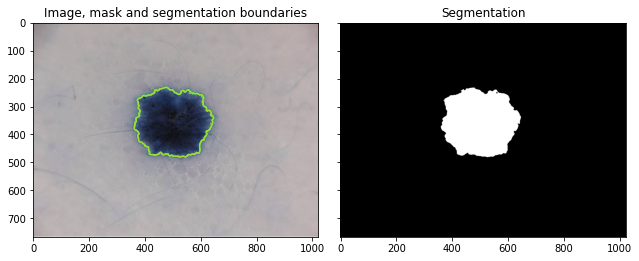

In [10]:
# ========================================================#
# Use scikit-image to perform Image Segmentation

# prepare training labels to train the model, where
# 1 indiciates normal tissue and
# 1000 is cancerous tissue
training_labels = np.zeros(image.shape[:2], dtype=np.uint8)
training_labels = np.add(label_grey, training_labels)
training_labels[training_labels == 0] = 1

# perform training
sigma_min = 1
sigma_max = 16
features_func = partial(
    feature.multiscale_basic_features,
    intensity=True,
    edges=False,
    texture=True,
    sigma_min=sigma_min,
    sigma_max=sigma_max,
    channel_axis=-1,
)

# obtain features from image
features = features_func(image)

# define random forest
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=10, max_samples=0.05)

# fit forest to features from original image and labeled image
clf = future.fit_segmenter(training_labels, features, clf)

# predict labels after training
# result will be array of 1's (normal) and 1000's (lesion)
result = future.predict_segmenter(features, clf)

# plot results
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(image, result, mode="thick"))
ax[0].contour(training_labels)
ax[0].set_title("Image, mask and segmentation boundaries")
ax[1].imshow(result, cmap=plt.cm.gray)
ax[1].set_title("Segmentation")
fig.tight_layout()

We can see on the left our original image with the predicted segmentation between the normal and cancerous tissue in green. On the right we can see the segmentation with black indicating normal tissue and white cancerous tissue.

**Analyzing Accuracy**

We will next analyze the performance of scikit-image by computing the accuracy. We will do so by comparing the result from scene segmentation to the true annotated image.

Our metrics for measuring accuracy are as follows.

*Precision-Recall Curve*
- Precision: also known as positive predictive value, the number of true positives (TP) divided by the total number of positives (true positive (TP) + false positive (FP)) for a given class, or
$$Precision = \frac{TP}{TP + FP}$$

- Recall: the number of true positives (TP) divided by the total number of predicted results (true positive (TP) + false negative (FN)) for a given class
$$Recall = \frac{TP}{TP + FN}$$

Precision and recall are often presented together as a Precision-Recall curve, as will be done in this tutorial. It is desirable that both values are close to 1.

*False Splits and Merges*
- False Splits: the fraction of times the classifier incorrectly segments two regions of the image to be normal and lesion when actually it is just one category
- False Merges: the fraction of times the classifier incorrectly identifies a region of the image to be only normal or cancerous when actually two separate categories occupy this region

False splits and false merges are often presented together in one graph, as we will do momentarily. It is desirable for these values to be close to 0.

*Dice Score*
- Sorensen-Dice Coefficient: also known as the dice score, this is a measure of how similar two images are, defined as 
$$Dice 
= \frac{2|X \cap Y|}{|X| + |Y|}$$
where $X$ and $Y$ are the sets of pixels in the true annotated image and the predicted labels. The numerator is finding where they intersect and have the same pixel labels, and the numerator is finding the total number of pixels. It is desirable for this value to be close to 1.

In [11]:
# ========================================================#
# Analyze the accuracy by looking at
# precision, recall, false splits, false merges, dice score

# correction so that the "normal" label for the predicted
# array matches that of the true array (both "0")
result[result == 1] = 0

# calculate error, precision, recall, splits, merges, dice
error, precision, recall = adapted_rand_error(label_grey, result)
splits, merges = variation_of_information(label_grey, result)
dice = get_dice(label_grey, result)

# print results
print(f"Adapted Rand error: {error}")
print(f"Adapted Rand precision: {precision}")
print(f"Adapted Rand recall: {recall}")
print(f"False Splits: {splits}")
print(f"False Merges: {merges}")
print(f"Dice Coefficient: {dice}")

Adapted Rand error: 0.010404807665880922
Adapted Rand precision: 0.9794046750630235
Adapted Rand recall: 1.0
False Splits: 0.014560392566033066
False Merges: 0.014377515154030181
Dice Coefficient: 0.9985329274857949


Evidently, based on these numerical results, it appears that scikit-image did a good job of scene segmentation, and so we next test it on other images in the dataset.

**Testing the Model**

We will now use this trained classifier to perform scene segmentation on a few other images, looking at the visual output and our measures of accuracy.

Adapted Rand error: 0.3258922114691747
Adapted Rand precision: 0.5084182429760788
Adapted Rand recall: 1.0
False Splits: 0.5572718746422476
False Merges: 0.6806071556689297
Dice Coefficient: 0.8186149814893721


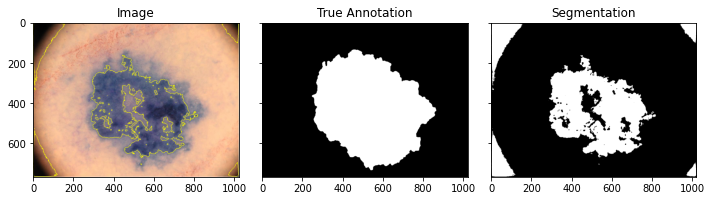

In [11]:
# ========================================================#
# perform scene segmentation on a third image

perform_scene_seg(images[2], labels_grey[2], clf)

Adapted Rand error: 0.28898841692624044
Adapted Rand precision: 0.5516043230002474
Adapted Rand recall: 1.0
False Splits: 0.307387447327057
False Merges: 0.4652813994844845
Dice Coefficient: 0.8871285436179794


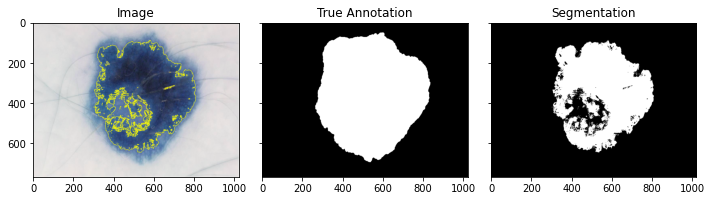

In [12]:
# ========================================================#
# perform scene segmentation on a third image

perform_scene_seg(images[3], labels_grey[3], clf)

Adapted Rand error: 0.2919986605281044
Adapted Rand precision: 0.5479892209659877
Adapted Rand recall: 1.0
False Splits: 0.3219221617565031
False Merges: 0.4501672997003304
Dice Coefficient: 0.9058509403296958


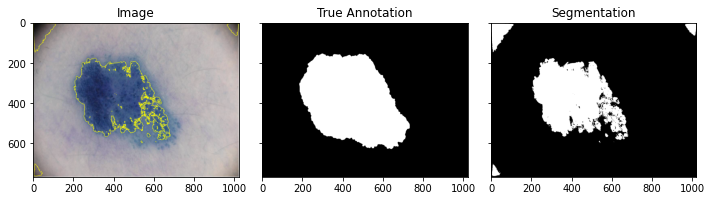

In [13]:
# ========================================================#
# perform scene segmentation on a third image

perform_scene_seg(images[8], labels_grey[8], clf)

**Testing the Model on 100 Images**

We will know look at the accuracy of the model after performing scene segmentation on 100 images.

In [14]:
# ========================================================#
# perform scene segmentation on 100 images

n = 100

# initialize arrays
error_list = np.zeros(n)
precision_list = np.zeros(n)
recall_list = np.zeros(n)
splits_list = np.zeros(n)
merges_list = np.zeros(n)
dice_list = np.zeros(n)
result_list = np.zeros(n, dtype=object)

# loop through each image and determine values
for i in np.arange(len(images[1:n])):
    # use classifier
    features = features_func(images[i])
    result = future.predict_segmenter(features, clf)
    result[result == 1] = 0  # correction for when compare to true

    # assess
    error, precision, recall = adapted_rand_error(labels_grey[i], result)
    splits, merges = variation_of_information(labels_grey[i], result)
    dice = get_dice(labels_grey[i], result)

    # add to list
    error_list[i] = error
    precision_list[i] = precision
    recall_list[i] = recall
    splits_list[i] = splits
    merges_list[i] = merges
    dice_list[i] = dice
    result_list[i] = result

Having obtained the predicted scene segmentations on our 100 images, we will now analyze the results in a graphical form.

Text(0.5, 1.0, 'Histogram of Dice Coefficients')

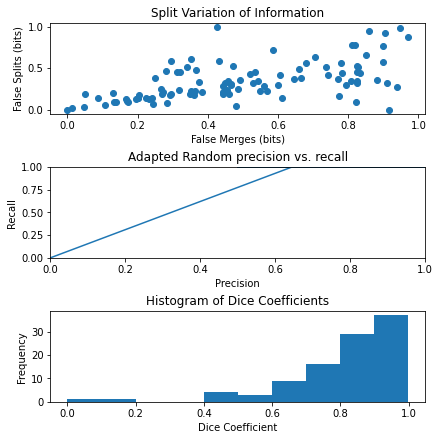

In [15]:
# ========================================================#
# analyze results

# create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)
ax = axes.ravel()

# plot merges, splits
ax[0].scatter(merges_list, splits_list)
ax[0].set_xlabel("False Merges (bits)")
ax[0].set_ylabel("False Splits (bits)")
ax[0].set_title("Split Variation of Information")

# plot precision, recall
ax[1].plot(precision_list, recall_list)
ax[1].set_xlabel("Precision")
ax[1].set_ylabel("Recall")
ax[1].set_title("Adapted Random precision vs. recall")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

# plot dice coefficients
ax[2].hist(dice_list)
ax[2].set_xlabel("Dice Coefficient")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Histogram of Dice Coefficients")

For the first graph, we can see the fraction of false merges plotted against false splits. For the second graph, we can see precision plotted against recall. For the third graph, we can see a histogram of dice coefficients. We can see that this last graph has a left skew with most images having very high dice scores.

## III. Conclusion

Evidently, we can see that Scikit-Image works well to perform scene-segmentation of images, but it is not perfect, and there is still great room for improvement in applying machine learning to perform scene segmentation.